In [18]:
!pip install xgboost
! pip install gplearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import csv
import re
from matplotlib import pyplot as plt

from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
dataset = pd.read_csv('/content/dockerImaesDataset.csv')
dataset.columns.values

In [2]:
dataset.describe()

Created on   # alternative base imgs   # tested dependences   \
count   305.000000                313.000000             313.000000   
mean    356.078490                  0.488818             158.881789   
std     616.765117                  1.059467             167.546383   
min       0.041667                  0.000000               0.000000   
25%       2.000000                  0.000000              54.000000   
50%      14.000000                  0.000000             112.000000   
75%     365.300000                  1.000000             169.000000   
max    3285.000000                  6.000000            1016.000000   

       # valnarble dependeces      critical      high        medium   \
count                313.000000  313.000000  313.000000   312.000000   
mean                  98.204473    2.201278    8.102236    32.278846   
std                  224.783278    7.281941   23.488044   107.798650   
min                    0.000000    0.000000    0.000000     0.000000   
25%                    0.000000    0.000000    0.000000     0.000000   
50%                   21.000000    0.000000    0.000000     0.500000   
75%                   64.000000    1.000000    4.000000    11.000000   
max                 2450.000000   79.000000  193.000000  1190.000000   

              low   # of downloads      secure  
count   313.000000    3.130000e+02  313.000000  
mean     53.226837    1.075449e+10    0.536741  
std     106.442245    3.068917e+10    0.499447  
min       0.000000    0.000000e+00    0.000000  
25%       0.000000    1.000000e+07    0.000000  
50%       9.000000    1.000000e+08    1.000000  
75%      52.000000    5.000000e+08    1.000000  
max    1064.000000    1.000000e+11    1.000000

In [34]:
# Convert the column to string format
dataset['Size'] = dataset['Size'].astype(str)

# Step 1: Parse the string
def extract_value(x):
    m = re.match(r'(\d+)([KMG]B)', x)
    if m:
        value = int(m.group(1))
        unit = m.group(2)
        return value, unit
    else:
        return None, None

dataset['Size'] = dataset['Size'].apply(lambda x: extract_value(x))

# Step 2: Convert to bytes
def convert_to_bytes(x):
    if x[0] is not None and x[1] is not None:
        if x[1] == 'KB':
            return x[0] * 1024
        elif x[1] == 'MB':
            return x[0] * 1024 * 1024
        elif x[1] == 'GB':
            return x[0] * 1024 * 1024 * 1024
        elif x[1] == 'B':
            return x[0] * 1024 
    else:
        return None

dataset['Size'] = dataset['Size'].apply(lambda x: convert_to_bytes(x))

# Step 3: Normalize the values
max_value = dataset['Size'].max()
dataset['Size'] = dataset['Size'] / max_value

# Step 4: Scale the values
dataset['Size'] = dataset['Size'] * 10

# Perform label encoding on the 'category' column
le = LabelEncoder()

dataset['package manager '] = dataset['package manager '].astype(str)
dataset['package manager '] = le.fit_transform(dataset['package manager '])

dataset['base image'] = dataset['base image'].str.split(':', expand=True)[0]
dataset['base image'] = le.fit_transform(dataset['base image'])

dataset['Tag '] = dataset['Tag '].astype(str)
dataset['Tag '] = le.fit_transform(dataset['Tag '])

dataset['secure'] = le.fit_transform(dataset['secure'])

dataset['# of downloads'].astype('float')
dataset['# of downloads'] = dataset['# of downloads'] / dataset['# of downloads'].max()



In [35]:
dataset

docker image  Tag   Created on       Size  \
0                        drupal   105        4.000  5.803109   
1                      postgres   105        5.000  3.927461   
2                       busybox   105        5.000       NaN   
3                        docker   105        6.000  1.575130   
4                          ruby   105        6.000  9.253886   
..                          ...   ...          ...       ...   
308              bitnami/apache   105        2.000       NaN   
309  atlassian/bitbucket-server    86        0.375       NaN   
310                     cimg/go     8        4.000       NaN   
311                 bitnami/git   105        2.000       NaN   
312                bitnami/ruby   105        2.000       NaN   

     package manager   base image  # alternative base imgs   \
0                   3          18                         4   
1                   3          44                         0   
2                   6          30                         0   
3                   0          35                         0   
4                   3          21                         4   
..                ...         ...                       ...   
308                 3          51                         0   
309                 3          51                         0   
310                 3          23                         1   
311                 3          51                         0   
312                 3          51                         0   

     # tested dependences   # valnarble dependeces    critical  high    \
0                      193                        98         1       2   
1                      147                        52         0       0   
2                        0                         0         0       0   
3                       23                         0         0       0   
4                      410                       248         5       2   
..                     ...                       ...       ...     ...   
308                    107                        49         0       0   
309                    170                        15         0       0   
310                    532                       190         0       0   
311                    124                        63         1       2   
312                    173                        93         1       2   

     medium   low   # of downloads  secure  
0        0.0    95    1.000000e-03       0  
1        0.0    52    1.000000e-02       1  
2        0.0     0    1.000000e-02       1  
3        0.0     0    4.500000e-08       1  
4       22.0   219    5.000000e-03       0  
..       ...   ...             ...     ...  
308      0.0    49    1.000000e-04       1  
309      2.0    13    1.000000e-04       1  
310      4.0     6    1.000000e-04       0  
311      1.0    59    1.000000e-04       1  
312      1.0    89    1.000000e-04       1  

[313 rows x 15 columns]

In [36]:
df = dataset.dropna()

X = df.drop(columns=['secure'], axis = 1)
y = df['secure']
X = X.drop(columns= ['docker image'], axis = 1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [38]:
# define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# compile the model
model.compile(loss='mse', optimizer='adam')

# train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# evaluate the model on the test set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')


Epoch 1/100
2/2 [==============================] - 1s 188ms/step - loss: 10791.8945 - val_loss: 16789.2266
Epoch 2/100
2/2 [==============================] - 0s 38ms/step - loss: 8696.0576 - val_loss: 13496.4746
Epoch 3/100
2/2 [==============================] - 0s 28ms/step - loss: 6581.6772 - val_loss: 10744.5557
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 4909.8149 - val_loss: 8291.9775
Epoch 5/100
2/2 [==============================] - 0s 32ms/step - loss: 3753.1301 - val_loss: 6069.3525
Epoch 6/100
2/2 [==============================] - 0s 33ms/step - loss: 2654.6196 - val_loss: 3995.9341
Epoch 7/100
2/2 [==============================] - 0s 31ms/step - loss: 1812.5636 - val_loss: 2434.4080
Epoch 8/100
2/2 [==============================] - 0s 29ms/step - loss: 1041.1389 - val_loss: 1386.2155
Epoch 9/100
2/2 [==============================] - 0s 43ms/step - loss: 699.7486 - val_loss: 763.9595
Epoch 10/100
2/2 [==============================] - 0s 30ms/s

In [39]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

Text(0.5, 0, 'Random Forest Feature Importance')

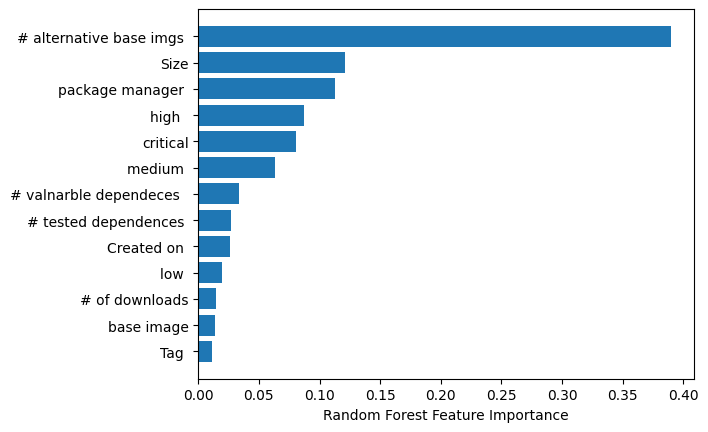

In [40]:
rf.feature_importances_
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns.values[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [41]:
SEED = 42
rfc = RandomForestClassifier(n_estimators=3, max_depth=2, random_state=SEED)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.90      1.00      0.95         9

    accuracy                           0.93        14
   macro avg       0.95      0.90      0.92        14
weighted avg       0.94      0.93      0.93        14



In [44]:
rfr = RandomForestRegressor(n_estimators=20, # 20 trees
                            max_depth=3, # 4 levels
                            random_state=SEED)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1
Mean Squared Error: 0.028928571428571435
Root Mean Squared Error: 0.17008401285415228


# GaussianProcessRegressor

In [ ]:
kernel = RBF()

# build the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

# fit the model on training data
gpr.fit(X_train, y_train)

# predict on test data
y_pred = gpr.predict(X_test)

# calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")


In [ ]:

# Initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=12)

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# XGBClassifier

In [ ]:
model = xgb.XGBClassifier()

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# calculate the error rate
cm = confusion_matrix(y_test, y_pred)
error_rate = 1 - cm.diagonal().sum() / cm.sum()
print("Error rate:", error_rate)


# SymbolicRegressor

In [ ]:
# Define the search space and other parameters
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min']
est_gp = SymbolicRegressor(population_size=5000, generations=20, tournament_size=20,
                            function_set=function_set, metric='mean absolute error',
                            verbose=1, random_state=0)

# Fit the model to the training data
est_gp.fit(X_train, y_train)

# Compute the R-squared value on the testing data
y_pred = est_gp.predict(X_test)
y_bar = y_test.mean()
TSS = ((y_test - y_bar) ** 2).sum()
RSS = ((y_pred - y_test) ** 2).sum()
r2 = 1 - RSS/TSS
print("R-squared: ", r2)

# UNSUPERVISED LEARNING 

# GaussianMixture

In [ ]:

# create a Gaussian Mixture Model with two components
gmm = GaussianMixture(n_components=2)

# fit the model to the data
gmm.fit(X)

# predict the labels of the data
labels = gmm.predict(X)

# calculate the accuracy of the model
accuracy = accuracy_score(y, labels)
# calculate the error rate of the model
error_rate = 1 - accuracy

print("Accuracy: ", accuracy)
print("Error rate: ", error_rate)


# KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X, kmeans.labels_)

print("The average silhouette score is:", silhouette_avg)
print("Inertia: ", inertia)


# kNN

In [ ]:
# Choose the value of K
k = 5

# Create the KNN model
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
